In [1]:
from numpy import array
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Concatenate, TimeDistributed
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense , LSTM, GRU, CuDNNLSTM,Bidirectional
from tensorflow.python.keras.layers import Flatten, Dropout, Lambda
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras import backend as K, losses
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np, pandas as pd
import os, re, csv, math, codecs
from tqdm import tqdm


In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /home/chandu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chandu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
MAX_NB_WORDS=100000

In [4]:
stopword_path = '/home/chandu/ckm/code/codemix/data/stop_hinglish'
stw = pd.read_csv(stopword_path, header=None)


In [5]:
stop_words.update(stw[0].tolist())

In [6]:
# from datasets import load_dataset

In [7]:
# model_checkpoint = "xlm-roberta-base"
# path = '/home/chandu/ckm/code/codemix/data/split_dataset/'
# from transformers import XLMRobertaTokenizerFast
# tokenizer =XLMRobertaTokenizerFast.from_pretrained(model_checkpoint, use_fast=True)
# train, test, valid = load_dataset('csv', data_files={'train':path+'train.csv','test':path+'test.csv','valid':path+'valid.csv'}, split=['train','test','valid'])

# train = pd.read_csv(path+'train.csv')
# train = pd.read_csv(path+'test.csv')
# train = pd.read_csv(path+'train.csv')

In [8]:
# def tokenize_function(examples):
#     return tokenizer(examples["tweets"],truncation=True, padding=True)
    
# encoded_train = train.map(tokenize_function, batched=True,num_proc=4)
# encoded_test  = test.map(tokenize_function, batched=True,num_proc=4)
# encoded_valid = valid.map(tokenize_function, batched=True,num_proc=4)

In [9]:
# tokenizer.decode(encoded_train['input_ids'][0])

# Load Embedding index

In [10]:
datapath='/home/chandu/ckm/code/codemix/data/Train and valid spli/wv.txt.vec'

embeddings_index = {}

In [11]:
with open(datapath) as fid:
    for i,line in enumerate(fid):
        if i==0:
            continue
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [12]:
len(embeddings_index)

28991

In [13]:
path = '/home/chandu/ckm/code/codemix/data/split_dataset/'
train = pd.read_csv(path+'train.csv')
test  = pd.read_csv(path+'test.csv')

In [14]:
print(train.shape)
print(test.shape)

(115000, 3)
(30000, 3)



# tokenizing the data with tokenizer from tensorflow

In [15]:
from sklearn.utils import shuffle 

max_seq_len = 30
raw_docs_train = train['tweets'].tolist()
raw_docs_test = test['tweets'].tolist() 
num_classes = train['labels'].nunique()

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

  0%|          | 0/115000 [00:00<?, ?it/s]

pre-processing train data...


100%|██████████| 30000/30000 [00:05<00:00, 5111.26it/s]


tokenizing input data...
dictionary size:  157324


# using CKM tokenizer

In [16]:
import sys

sys.path.append('/home/chandu/ckm/code/models/mymodels/')

In [17]:
# from ckm_tokenizer import *

# data_src = train['tweets'].tolist()
# src_num_words = 100000

# tokenizer_src = TokenizerWrap(texts=data_src,
#                               padding='post',
#                               reverse=False,
#                               num_words=src_num_words)



# tokens_src = tokenizer_src.tokens_padded

# print(tokens_src.shape)
# encoder_input_data = tokens_src
# print((encoder_input_data[0]))

# Shape and Train with LSTM
defining variables that used on training

In [18]:
#training params
batch_size = 32
num_epochs = 10

#model parameters
num_filters = 64 
embed_dim   = 100 
weight_decay= 1e-4

In [19]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 71931


In [20]:
model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
# model.add(Attention(max_seq_len))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           10000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 10,036,161
Trainable params: 36,161
Non-trainable params: 10,000,000
_______________________________________

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
y_train = train['labels']
y_train

0         0
1         0
2         1
3         1
4         1
         ..
114995    0
114996    0
114997    0
114998    0
114999    1
Name: labels, Length: 115000, dtype: int64

In [23]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)


history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/10
315/315 [==============================] - 23s 54ms/step - loss: 0.5924 - accuracy: 0.6763 - val_loss: 0.5043 - val_accuracy: 0.7541
Epoch 2/10
315/315 [==============================] - 16s 50ms/step - loss: 0.5069 - accuracy: 0.7510 - val_loss: 0.4924 - val_accuracy: 0.7588
Epoch 3/10
315/315 [==============================] - 16s 51ms/step - loss: 0.4947 - accuracy: 0.7583 - val_loss: 0.4865 - val_accuracy: 0.7627
Epoch 4/10
315/315 [==============================] - 16s 50ms/step - loss: 0.4853 - accuracy: 0.7639 - val_loss: 0.4820 - val_accuracy: 0.7639
Epoch 5/10
315/315 [==============================] - 16s 50ms/step - loss: 0.4762 - accuracy: 0.7678 - val_loss: 0.4781 - val_accuracy: 0.7666
Epoch 6/10
315/315 [==============================] - 16s 50ms/step - loss: 0.4686 - accuracy: 0.7737 - val_loss: 0.4762 - val_accuracy: 0.7691
Epoch 7/10
315/315 [==============================] - 16s 51ms/step - loss: 0.4632 - accuracy: 0.7765 - val_loss: 0.4749 - val_accuracy:

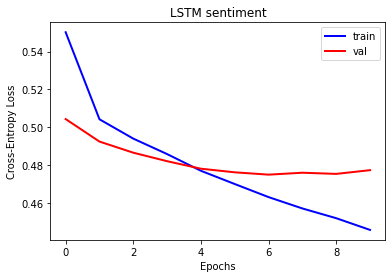

In [24]:
import matplotlib.pyplot as plt
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()


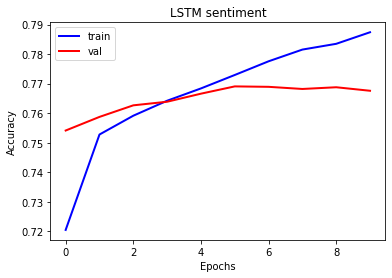

In [25]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [26]:
from print_ckm_metrics import metrics

In [27]:
from pandas.core.common import flatten

In [28]:
predictions =model.predict(word_seq_test)

In [29]:
predictions= np.array(list(flatten(predictions)))

In [30]:
predictions=1*(predictions >=0.5)
# predictions=(predictions >=0.5).astype(int)

In [31]:
y_true = test['labels'].to_numpy()
y_true

array([0, 1, 0, ..., 0, 1, 0])

In [32]:
metrics(y_true, predictions)

Accuracy score : 0.7665666666666666
micro f1 score:0.7665666666666666
micro auc score:0.7666547121934347
precision, recall, f1, support:(0.7665666666666666, 0.7665666666666666, 0.7665666666666666, None)
